# Compare $n_\mathrm{train}$ Dependence for Multiple Statistics and Bias Param Sets

This notebook computes and plots $\chi^2$ and FoM as a function of $n_\mathrm{train}$ for all combinations of statistics and bias parameter sets, for both the CV (fixed-cosmo) and coverage test sets.

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
from pathlib import Path
import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader, plotter, plot_utils, utils, generate_params as genp
%load_ext autoreload
%autoreload 2

2025-06-13 12:18:49.169529: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 12:18:49.398253: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-13 12:18:49.398295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-13 12:18:49.420889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 12:18:49.494480: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# --- Config ---
data_mode = 'muchisimocks'
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_params = '_p5_n10000'
tag_biasparams_arr = ['_biaszen_p4_n10000', '_biaszen_p4_n100000']
n_train_arr = [500, 1000, 2000, 4000, 6000, 8000, 10000]

In [3]:
def get_tags_inf(statistics, tag_biasparams, n_train_arr):
    tag_stats = '_' + '_'.join(statistics)
    return [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for n_train in n_train_arr]

In [25]:
param_names = utils.param_names_all_ordered
cosmo_param_names = utils.cosmo_param_names_ordered
bias_param_names = utils.biasparam_names_ordered

In [17]:
def get_param_names(tag_params, tag_biasparams):
    params_df, _, biasparams_df, _, _, _ = data_loader.load_params(tag_params, tag_biasparams)
    cosmo_param_names_vary = params_df.columns.tolist() if params_df is not None else []
    bias_param_names_vary = biasparams_df.columns.tolist() if biasparams_df is not None else []
    return cosmo_param_names_vary, bias_param_names_vary

In [26]:
def get_cv_test_arrays(tags_inf, n_train_arr, statistics, tag_biasparams):
    tag_params_test_fixed = '_quijote_p0_n1000'
    tag_biasparams_test_fixed = '_b1000_p0_n1'
    tag_datagen_test_fixed = ''
    tag_stats = '_' + '_'.join(statistics)
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_datagen_test_fixed + '_mean']*len(tags_inf)
    theta_test_pred_fixed_arr, covs_test_pred_fixed_arr, n_train_arr_filtered = [], [], []
    for i, tag_inf in enumerate(tags_inf):
        dir_sbi = f'../results/results_sbi/sbi{tag_inf}'
        fn_samples_test_pred = f'{dir_sbi}/samples_test{tags_test[i]}_pred.npy'
        if not Path(fn_samples_test_pred).exists():
            print(f"Missing: {fn_samples_test_pred}, skipping n_train={n_train_arr[i]}")
            continue
        theta_test_pred_fixed, covs_test_pred_fixed, _ = utils.get_moments_test_sbi(tag_inf, tag_test=tags_test[i])
        theta_test_pred_fixed_arr.append(theta_test_pred_fixed[0])
        covs_test_pred_fixed_arr.append(covs_test_pred_fixed[0])
        n_train_arr_filtered.append(n_train_arr[i])
    # Load the true test value for the fixed-cosmology test set
    # Use the same param_names as in the predictions
    
    #cosmo_param_names_vary, bias_param_names_vary = get_param_names(tag_params_test_fixed, tag_biasparams_test_fixed)
    theta_test_true = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                cosmo_param_names_vary=cosmo_param_names, bias_param_names_vary=bias_param_names)
    print(theta_test_true)
    # theta_test_true = None
    # if len(theta_test_pred_fixed_arr) > 0:
    #     # Use the param_names from the first available prediction
    #     _, _, param_names = utils.get_moments_test_sbi(tags_inf[0], tag_test=tags_test[0])
    #     theta_test = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed)
    #     # Get the true values in the same order as param_names
    #     idxs = [list(theta_test.dtype.names).index(pn) if hasattr(theta_test, 'dtype') and theta_test.dtype.names else i for i, pn in enumerate(param_names)]
    #     theta_test_true = theta_test[0][idxs] if hasattr(theta_test, 'dtype') and theta_test.dtype.names else theta_test[0]
    return np.array(theta_test_pred_fixed_arr), np.array(covs_test_pred_fixed_arr), n_train_arr_filtered, theta_test_true

In [27]:
def get_coverage_test_arrays(tags_inf, statistics, tag_biasparams, n_train_arr):
    # Coverage test set
    tag_params_test = '_test_p5_n1000'
    tag_biasparams_test = '_biaszen_p4_n1000'
    tag_datagen_test = ''
    tag_stats = '_' + '_'.join(statistics)
    tag_data_test = '_'+data_mode + tag_stats + tag_params_test + tag_biasparams_test + tag_datagen_test
    tags_data_test = [tag_data_test]*len(tags_inf)
    param_names_show = utils.param_names_all_ordered
    theta_true_arr, theta_pred_arr, vars_pred_arr, covs_pred_arr, n_train_arr_filtered = [], [], [], [], []
    for i, tag_inf in enumerate(tags_inf):
        dir_sbi = f'../results/results_sbi/sbi{tag_inf}'
        fn_samples_test_pred = f'{dir_sbi}/samples_test{tags_data_test[i]}_pred.npy'
        if not Path(fn_samples_test_pred).exists():
            print(f"Missing: {fn_samples_test_pred}, skipping n_train={n_train_arr[i]}")
            continue
        _theta_test_pred, _covs_test_pred, param_names = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i])
        theta_test = data_loader.load_theta_test(tag_params_test, tag_biasparams_test)
        theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
        for param_name_show in param_names_show:
            if param_name_show in param_names:
                idx_pn = list(param_names).index(param_name_show)
                theta_true_inf.append(theta_test[:,idx_pn])
                theta_pred_inf.append(_theta_test_pred[:,idx_pn])
                vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            else:
                nans = np.full(_theta_test_pred.shape[0], np.nan)
                theta_true_inf.append(nans)
                theta_pred_inf.append(nans)
                vars_pred_inf.append(nans)
        theta_true_arr.append(np.array(theta_true_inf).T)
        theta_pred_arr.append(np.array(theta_pred_inf).T)
        vars_pred_arr.append(np.array(vars_pred_inf).T)
        covs_pred_arr.append(_covs_test_pred)
        n_train_arr_filtered.append(n_train_arr[i])
    return (np.array(theta_true_arr), np.array(theta_pred_arr),
            np.array(vars_pred_arr), np.array(covs_pred_arr), n_train_arr_filtered)

In [28]:
def compute_chi2_fom_cv(theta_test_pred_fixed_arr, covs_test_pred_fixed_arr, theta_test_true):
    chi2_arr, fom_arr = [], []
    for i in range(len(theta_test_pred_fixed_arr)):
        chi2_arr.append(utils.chi2(theta_test_true, theta_test_pred_fixed_arr[i], covs_test_pred_fixed_arr[i]))
        fom_arr.append(utils.figure_of_merit(covs_test_pred_fixed_arr[i]))
    return np.array(chi2_arr), np.array(fom_arr)

def compute_chi2_fom_coverage(theta_true_arr, theta_pred_arr, covs_pred_arr):
    chi2_arr, fom_arr = [], []
    for i in range(len(theta_true_arr)):
        chi2_arr.append(utils.chi2(theta_true_arr[i], theta_pred_arr[i], covs_pred_arr[i]))
        fom_arr.append(utils.figure_of_merit(covs_pred_arr[i]))
    return np.array(chi2_arr), np.array(fom_arr)

In [29]:
# --- Main loop over all combinations ---
results_cv = {}
results_coverage = {}
for statistics in statistics_arr:
    for tag_biasparams in tag_biasparams_arr:
        tags_inf = get_tags_inf(statistics, tag_biasparams, n_train_arr)
        cosmo_param_names_vary, bias_param_names_vary = get_param_names(tag_params, tag_biasparams)
        # CV test set
        param_names_vary = cosmo_param_names_vary + bias_param_names_vary
        theta_test_pred_fixed_arr, covs_test_pred_fixed_arr, n_train_arr_cv, theta_test_true = get_cv_test_arrays(tags_inf, n_train_arr, statistics, tag_biasparams)
        chi2_cv, fom_cv = compute_chi2_fom_cv(theta_test_pred_fixed_arr, covs_test_pred_fixed_arr, theta_test_true)
        results_cv[(tuple(statistics), tag_biasparams)] = (chi2_cv, fom_cv, n_train_arr_cv)
        # Coverage test set
        theta_true_arr, theta_pred_arr, vars_pred_arr, covs_pred_arr, n_train_arr_cov = get_coverage_test_arrays(tags_inf, statistics, tag_biasparams, n_train_arr)
        chi2_coverage, fom_coverage = compute_chi2_fom_coverage(theta_true_arr, theta_pred_arr, covs_pred_arr)
        results_coverage[(tuple(statistics), tag_biasparams)] = (chi2_coverage, fom_coverage, n_train_arr_cov)

[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.    ]
Missing: ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain500/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_pred.npy, skipping n_train=500
Missing: ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain1000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_pred.npy, skipping n_train=1000
Missing: ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain2000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_pred.npy, skipping n_train=2000
Missing: ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain4000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_pred.npy, skipping n_train=4000
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.    ]
Missing: ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n100000_ntrain500/samples_test_muchisimocks_pk_test_p5_n1000_biasze

In [30]:
n_dof = len(theta_true_arr[0][0])
n_dof

9

<Figure size 640x480 with 0 Axes>

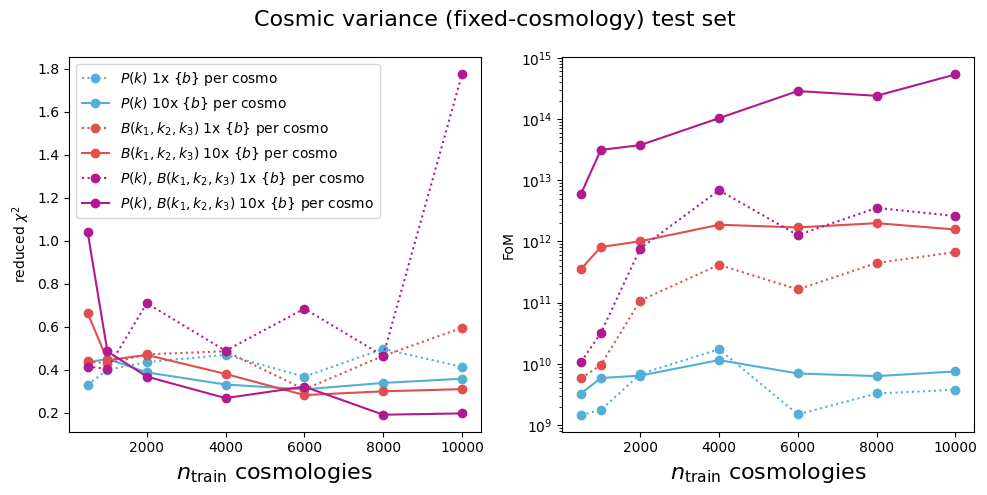

In [31]:
# --- Plotting ---
# Define custom colors for each statistics type
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
color_map = {
    ('pk',): color_pk,
    ('bispec',): color_bispec,
    ('pk', 'bispec'): color_pkbispec
}
linestyle_map = {
    '_biaszen_p4_n100000': '-',
    '_biaszen_p4_n10000': ':'
}

# Clear any existing plots and set up fresh figure
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Cosmic variance (fixed-cosmology) test set', fontsize=16)

# Left subplot - Chi-squared
for i, ((statistics, tag_biasparams), (chi2_cv, fom_cv, n_train_arr_cv)) in enumerate(results_cv.items()):
    stat_key = tuple(statistics)
    color = color_map.get(stat_key, f'C{i%10}')
    linestyle = linestyle_map.get(tag_biasparams, '-')
    label = f"{utils.get_stat_label(statistics)} {utils.labels_biasparams[tag_biasparams]}"
    ax1.plot(n_train_arr_cv, chi2_cv/n_dof, marker='o', color=color, linestyle=linestyle, label=label)

ax1.set_xlabel(r'$n_\text{train}$ cosmologies', fontsize=16)
ax1.set_ylabel('reduced $\\chi^2$')
ax1.legend(fontsize=10)

# Right subplot - FoM
for i, ((statistics, tag_biasparams), (chi2_cv, fom_cv, n_train_arr_cv)) in enumerate(results_cv.items()):
    stat_key = tuple(statistics)
    color = color_map.get(stat_key, f'C{i%10}')
    linestyle = linestyle_map.get(tag_biasparams, '-')
    label = f"{utils.get_stat_label(statistics)} {utils.labels_biasparams[tag_biasparams]}"
    ax2.plot(n_train_arr_cv, fom_cv, marker='o', color=color, linestyle=linestyle, label=label)

ax2.set_xlabel(r'$n_\text{train}$ cosmologies', fontsize=16)
ax2.set_ylabel('FoM')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

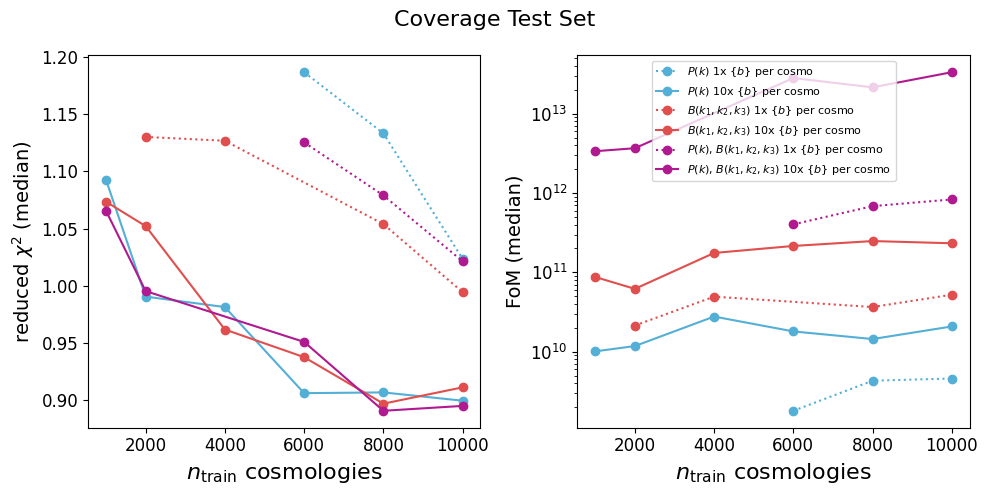

In [32]:
# --- Coverage plot in a separate cell ---
# Clear any existing plots and set up fresh figure
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Coverage Test Set', fontsize=16)

n_train_ticks = n_train_arr[2:]

# Left subplot - Chi-squared
for i, ((statistics, tag_biasparams), (chi2_coverage, fom_coverage, n_train_arr_cov)) in enumerate(results_coverage.items()):
    stat_key = tuple(statistics)
    color = color_map.get(stat_key, f'C{i%10}')
    linestyle = linestyle_map.get(tag_biasparams, '-')
    label = f"{utils.get_stat_label(statistics)} {utils.labels_biasparams[tag_biasparams]}"
    ax1.plot(n_train_arr_cov, np.median(chi2_coverage/n_dof, axis=1), marker='o', color=color, linestyle=linestyle, label=label)

ax1.set_xlabel(r'$n_\mathrm{train}$ cosmologies', fontsize=16)
ax1.set_ylabel('reduced $\\chi^2$ (median)', fontsize=14)
ax1.set_xticks(n_train_ticks)
ax1.set_xticklabels([str(x) for x in n_train_ticks], fontsize=12)
ax1.tick_params(axis='y', labelsize=12)

# Right subplot - FoM
for i, ((statistics, tag_biasparams), (chi2_coverage, fom_coverage, n_train_arr_cov)) in enumerate(results_coverage.items()):
    stat_key = tuple(statistics)
    color = color_map.get(stat_key, f'C{i%10}')
    linestyle = linestyle_map.get(tag_biasparams, '-')
    label = f"{utils.get_stat_label(statistics)} {utils.labels_biasparams[tag_biasparams]}"
    ax2.plot(n_train_arr_cov, np.median(fom_coverage, axis=1), marker='o', color=color, linestyle=linestyle, label=label)

ax2.legend(fontsize=8)
ax2.set_xlabel(r'$n_\mathrm{train}$ cosmologies', fontsize=16)
ax2.set_ylabel('FoM (median)', fontsize=14)
ax2.set_xticks(n_train_ticks)
ax2.set_xticklabels([str(x) for x in n_train_ticks], fontsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()